In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
def CalcPrincipal(payment, rate,years):
    """If the initial principal value of the loan is unknown, 
    enter the monthly payment (including monthly principal plus interest, but no additional costs like insurance or escrow, 
    yearly interest rate percent, and total term of the loan"""
    c = rate*0.01/12. #convert the yearly rate into monlthly
    d = (c*(1 + c)**(12*years))/float( (1 + c)**(12*years) - 1 )
    return payment/d
CalcPrincipal(825.43, 4.5,30)

162907.82148068308

#### Define our Mortgage function here. This will calculate the principal and interest at the end of each month, and it will also record total contributions and remaining loan amount. The output will show these values in a dataframe.

In [3]:
def todate(x, startmonth, startyear):
    '''Uses the number of months that has gone by since taking out the loan, 
    with the starting date to convert current month into the current date'''
    #finds the month by using the remainder, input is in 1-12 for months format, 
    #so it subtracts 1 before dividing then adds 1 as an offset to be 1-12
    mod = (x+startmonth-1)%12 + 1 
    #the current year, checks to make sure the current month number plus the start month is less than 12
    rem = startyear + (x+startmonth-1)//12 
    return str(mod) + '/' + str(rem)

def Mortgage(p,r,t, startmonth = 0, startyear = 2003):
    Bal=[p]
    TotC=[0]
    TotI = [0] 
    mrate =1+r*0.01/12. #yearly rate is not a result of compounding monthly interest, so divide by 12
    Months=range(12*t+1)

    I=[0]
    P=[0]

    c = r*0.01/12.
    if r == 0:
        InMo = 0
    else:    
        InMo = p*(c*(1 + c)**(12*t))/float( (1 + c)**(12*t) - 1 )
    date = []
    
    for i in Months:
        if Bal[i]>InMo: #while our balance is above the minimum monthly payment
            Bal.append( Bal[i]*mrate - InMo) #Balance of the Loan
            TotC.append(TotC[i] + InMo) #Total contribution
            TotI.append(TotI[i] + Bal[i]*(mrate-1)) #What has been paid so far in total as interest
            I.append(Bal[i]*(mrate-1)) #What portion of this monthly payment is interest
            P.append(InMo-I[i+1]) #subtract the interest from this month and principal remains
        else:
            Bal.append(0)
            TotC.append(TotC[i]+Bal[i])
            TotI.append(TotI[i])#there will be no more interest paid (check if I need to add interest first)
            Months = Months[:i+2] #two more than the current index
            I.append(0)
            P.append(Bal[i]-I[i+1])
            break
        date.append(todate(i,startmonth,startyear))
    #add the last two dates
    date.append(todate(i,startmonth,startyear))
    date.append(todate(i+1,startmonth,startyear))
    
    df = pd.DataFrame([Months, date, Bal, TotC, TotI, I, P], index='Month Date Balance Contributions Interest I P'.split()).T
    df['Principal'] = df['Contributions']-df['Interest']
    df.set_index('Date', inplace=True)

    for i in df.drop('Month', axis=1).columns:
        df[i] = df[i].apply(lambda x: "{:.2f}".format(x) )
    df = df.apply(pd.to_numeric)

    print('Monthly Payment: $' + str(round(InMo,3)) + 
          '\n Total Payment over Loan Term: $' + str(df['Contributions'].iloc[-1]))
    return df

Monthly Payment: $841.098
 Total Payment over Loan Term: $302792.0


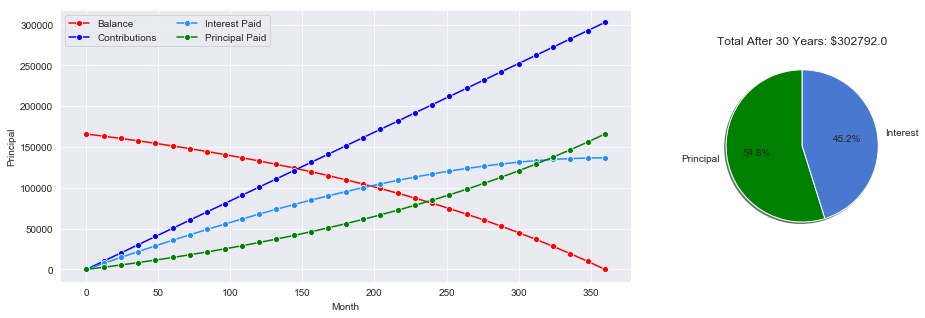

In [4]:
#Here is an example along with charts to visualize the data
Principal = 166000
rate = 4.5
years = 30

df1 = Mortgage(Principal,rate,years, 4, 2003)

columns = ['Principal', 'Interest']
a = df1[columns].tail(1).round(3).values[0]

sns.set_style('darkgrid')
sns.set_palette('muted')

#Create a line plot
f, ax = plt.subplots(1,2,figsize=(15,5), gridspec_kw={'width_ratios': [3, 1]})

sns.lineplot(x="Month", y="Balance", data=df1[::12],label="Balance", color="r", marker = 'o', ax = ax[0])
sns.lineplot(x="Month", y="Contributions", data=df1[::12],label="Contributions", color="b", marker = 'o', ax = ax[0])
sns.lineplot(x="Month", y="Interest", data=df1[::12],label="Interest Paid", color="dodgerblue", marker = 'o', ax = ax[0])
sns.lineplot(x="Month", y="Principal", data=df1[::12],label="Principal Paid", color="green", marker = 'o', ax = ax[0])
ax[0].legend(ncol=2, loc="upper left", frameon=True)

#Create a pie chart
ax[1].pie(a, startangle=90, shadow=True, colors = ['green','#4878d0'], labels = columns, autopct='%1.1f%%')
ax[1].set_title('Total After ' + str(years)+ ' Years: $' + str(df1['Contributions'].iloc[-1]))
plt.show()

In [13]:
#can print out a table with a monthly summary
df1[::36]

,Month,Balance,Contributions,Interest,I,P,Principal
Date,,,,,,,
4/2003,0,166000.00,0.00,0.00,0.00,0.00,0.00
4/2006,36,157591.40,30279.51,21870.92,591.90,249.20,8408.60
4/2009,72,147969.89,60559.03,42528.92,555.96,285.14,18030.11
4/2012,108,136960.49,90838.54,61799.03,514.83,326.27,29039.51
4/2015,144,124363.01,121118.06,79481.06,467.76,373.34,41636.99
4/2018,180,109948.37,151397.57,95345.94,413.91,427.19,56051.63
4/2021,216,93454.44,181677.08,109131.53,352.29,488.81,72545.56
4/2024,252,74581.31,211956.60,120537.91,281.78,559.32,91418.69
4/2027,288,52985.77,242236.11,129221.88,201.10,640.00,113014.23


#### We can make an interactive visualization for a web site, with user input as the starting values

In [14]:
from ipywidgets import interactive, fixed

def makepie(P, r, y, mo, sy):
    df1 = Mortgage(P,r,y,mo,sy)
    columns = ['Principal', 'Interest']
    a = df1[columns].tail(1).round(3).values[0]
    plt.pie(a, startangle=90, shadow=True, colors = ['green','#4878d0'], labels = columns, autopct='%1.1f%%')
    plt.show()

Principal = float(input('Loan Amount ($): '))
rate = float(input('Yearly % Interest Rate: '))
years = int(input('Years of Loan Term: '))

w=interactive(makepie, P = (1,Principal*2-1), r =(rate-1,rate+1), y = (max(0,years-15),min(2*years,years+15)), mo= fixed(4), sy= fixed(2020))
w

Loan Amount ($): 435000
Yearly % Interest Rate: 3.5
Years of Loan Term: 30


interactive(children=(FloatSlider(value=435000.0, description='P', max=869999.0, min=1.0), FloatSlider(value=3…

#### We can also compare two different loans

Monthly Payment: $2245.223
 Total Payment over Loan Term: $808273.91
Monthly Payment: $3452.908
 Total Payment over Loan Term: $621514.87


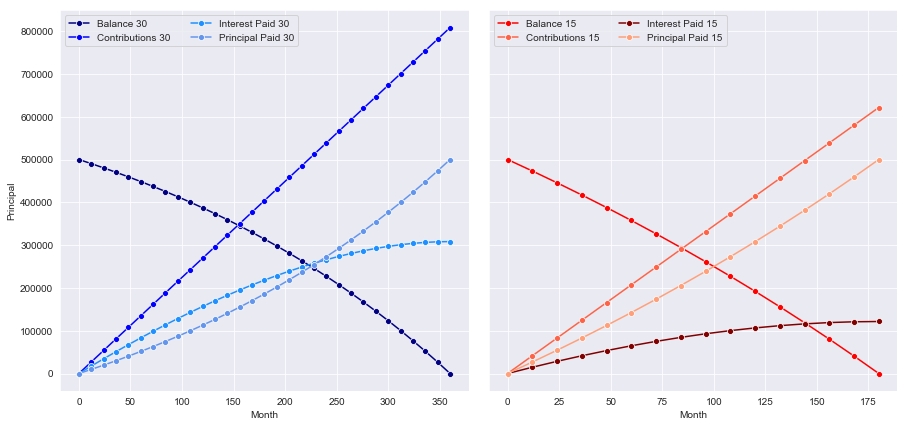

In [150]:
df1 = Mortgage(500000,3.5,30, 6,2020)

f, ax = plt.subplots(1,2,figsize=(15,7), sharey=True, gridspec_kw={'width_ratios': [1, 1]})
f.subplots_adjust(wspace=0.05, hspace=0)

sns.lineplot(x="Month", y="Balance", data=df1[::12], marker = 'o', label="Balance 30", color="navy", ax = ax[0])
sns.lineplot(x="Month", y="Contributions", data=df1[::12], marker = 'o', label="Contributions 30", color="b", ax = ax[0])
sns.lineplot(x="Month", y="Interest", data=df1[::12], marker = 'o', label="Interest Paid 30", color="dodgerblue", ax = ax[0])
sns.lineplot(x="Month", y="Principal", data=df1[::12], marker = 'o', label="Principal Paid 30", color="cornflowerblue", ax = ax[0])


df2 = Mortgage(500000,3,15, 6,2020)

sns.lineplot(x="Month", y="Balance", data=df2[::12], marker = 'o',label="Balance 15", color="red", ax = ax[1])
sns.lineplot(x="Month", y="Contributions", data=df2[::12], marker = 'o',label="Contributions 15",  color="tomato", ax = ax[1])
sns.lineplot(x="Month", y="Interest", data=df2[::12], marker = 'o',label="Interest Paid 15", color="maroon", ax = ax[1])
sns.lineplot(x="Month", y="Principal", data=df2[::12], marker = 'o',label="Principal Paid 15", color="lightsalmon", ax = ax[1])

ax[0].legend(ncol=2, loc="upper left", frameon=True)

ax[1].legend(ncol=2, loc="upper left", frameon=True)

#### With this we can see that a longer term loan has lower monthly payments, but significantly more is in the form of interest.
#### Especially in the beginning, the 30 year loan monthly payments are mostly interest. 
#### The 15 year loan ends up costing significantly less in total as a result of lower interest payments each month.

Future direction for this project: 

Add a down payment option (in dollars or percent)

Add a payment frequency variable (weekly, monthly, yearly, etc)

Add option to pay higher than minimum monthly payment 

Variable interest rate option?

Convert into a web app